In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv1D, Flatten, BatchNormalization, LeakyReLU, Input, Dropout, Dense, Add, Dropout, LSTM
from tensorflow.keras import Model, datasets, models
from tensorflow.keras.optimizers import Adam
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
data = pd.read_csv('google.csv', date_parser=True)

In [3]:
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,49.813286,51.835709,47.800831,49.982655,49.982655,44871300
1,2004-08-20,50.316402,54.336334,50.062355,53.952770,53.952770,22942800
2,2004-08-23,55.168217,56.528118,54.321388,54.495735,54.495735,18342800
3,2004-08-24,55.412300,55.591629,51.591621,52.239193,52.239193,15319700
4,2004-08-25,52.284027,53.798351,51.746044,52.802086,52.802086,9232100
...,...,...,...,...,...,...,...
3804,2019-09-30,1220.969971,1226.000000,1212.300049,1219.000000,1219.000000,1404100
3805,2019-10-01,1219.000000,1231.229980,1203.579956,1205.099976,1205.099976,1273500
3806,2019-10-02,1196.979980,1196.979980,1171.290039,1176.630005,1176.630005,1615100
3807,2019-10-03,1180.000000,1189.060059,1162.430054,1187.829956,1187.829956,1621200


In [4]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3809.000000,3809.000000,3809.000000,3809.000000,3809.000000,3.809000e+03
mean,477.021219,481.312940,472.442959,476.979070,476.979070,7.181291e+06
std,325.569981,328.160631,323.008258,325.744535,325.744535,8.108893e+06
min,49.409801,50.680038,47.800831,49.818268,49.818268,7.900000e+03
25%,235.616852,238.615616,233.484848,235.517227,235.517227,1.831000e+06
50%,313.823700,316.558472,310.386597,313.290710,313.290710,4.492500e+06
75%,703.619995,711.478027,695.719971,704.239990,704.239990,9.330100e+06
max,1274.000000,1289.270020,1266.295044,1287.579956,1287.579956,8.254150e+07


In [5]:
data.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

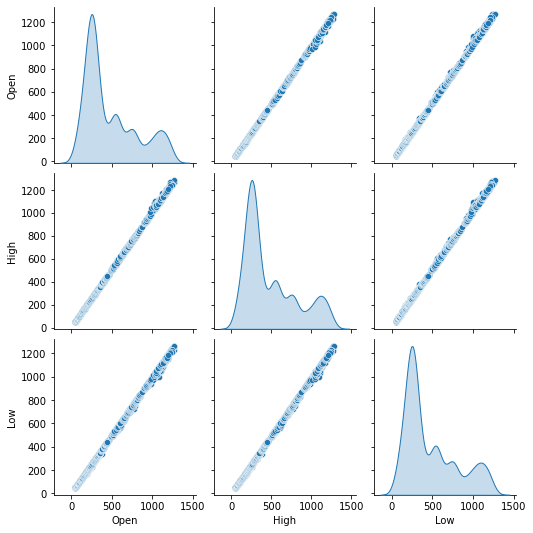

In [6]:
sns.pairplot(data[['Open','High','Low']], diag_kind='kde')

In [7]:
train_data = data[data['Date']<'2019-01-01'].copy()

In [8]:
train_data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,49.813286,51.835709,47.800831,49.982655,49.982655,44871300
1,2004-08-20,50.316402,54.336334,50.062355,53.952770,53.952770,22942800
2,2004-08-23,55.168217,56.528118,54.321388,54.495735,54.495735,18342800
3,2004-08-24,55.412300,55.591629,51.591621,52.239193,52.239193,15319700
4,2004-08-25,52.284027,53.798351,51.746044,52.802086,52.802086,9232100
...,...,...,...,...,...,...,...
3612,2018-12-24,973.900024,1003.539978,970.109985,976.219971,976.219971,1590300
3613,2018-12-26,989.010010,1040.000000,983.000000,1039.459961,1039.459961,2373300
3614,2018-12-27,1017.150024,1043.890015,997.000000,1043.880005,1043.880005,2109800
3615,2018-12-28,1049.619995,1055.560059,1033.099976,1037.079956,1037.079956,1414800


In [9]:
test_data = data[data['Date']>='2019-01-01'].copy()

In [10]:
test_data

,Date,Open,High,Low,Close,Adj Close,Volume
3617,2019-01-02,1016.570007,1052.319946,1015.710022,1045.849976,1045.849976,1532600
3618,2019-01-03,1041.000000,1056.979980,1014.070007,1016.059998,1016.059998,1841100
3619,2019-01-04,1032.589966,1070.839966,1027.417969,1070.709961,1070.709961,2093900
3620,2019-01-07,1071.500000,1074.000000,1054.760010,1068.390015,1068.390015,1981900
3621,2019-01-08,1076.109985,1084.560059,1060.530029,1076.280029,1076.280029,1764900
...,...,...,...,...,...,...,...
3804,2019-09-30,1220.969971,1226.000000,1212.300049,1219.000000,1219.000000,1404100
3805,2019-10-01,1219.000000,1231.229980,1203.579956,1205.099976,1205.099976,1273500
3806,2019-10-02,1196.979980,1196.979980,1171.290039,1176.630005,1176.630005,1615100
3807,2019-10-03,1180.000000,1189.060059,1162.430054,1187.829956,1187.829956,1621200


In [11]:
x_data = train_data.drop(['Date', 'Adj Close'], axis=1)

In [12]:
x_data

,Open,High,Low,Close,Volume
0,49.813286,51.835709,47.800831,49.982655,44871300
1,50.316402,54.336334,50.062355,53.952770,22942800
2,55.168217,56.528118,54.321388,54.495735,18342800
3,55.412300,55.591629,51.591621,52.239193,15319700
4,52.284027,53.798351,51.746044,52.802086,9232100
...,...,...,...,...,...
3612,973.900024,1003.539978,970.109985,976.219971,1590300
3613,989.010010,1040.000000,983.000000,1039.459961,2373300
3614,1017.150024,1043.890015,997.000000,1043.880005,2109800
3615,1049.619995,1055.560059,1033.099976,1037.079956,1414800


In [13]:
scaler = MinMaxScaler()

x_data = scaler.fit_transform(x_data)

x_data.shape

(3617, 5)

In [14]:
x_train = []
y_train = []

# we will feed 60 samples and 61st is predicted. 
# In this manner we will learn LSTM network to predict based on last 60 samples

for i in range(60, x_data.shape[0]):
    x_train.append(x_data[i-60:i])
    y_train.append(x_data[i,0])

In [15]:
x_train = np.array(x_train)
y_train = np.array(y_train)

In [16]:
x_train.shape

(3557, 60, 5)

In [17]:
y_train.shape

(3557,)

In [18]:
def stock():
    
    I = Input(shape=[x_train.shape[1],5])
    
    L1 = LSTM(units=50, activation='relu', return_sequences=True)(I)
    D1 = Dropout(0.2)(L1)
    
    L2 = LSTM(units=60, activation='relu', return_sequences=True)(D1)
    D2 = Dropout(0.2)(L2)
    
    L3 = LSTM(units=70, activation='relu', return_sequences=True)(D2)
    D3 = Dropout(0.2)(L3)
    
    L4 = LSTM(units=100, activation='relu')(D3)
    D4 = Dropout(0.2)(L4)
    
    out = Dense(1)(D4)
    
    model = Model(inputs=I, outputs=out)
    
    return model

In [19]:
model = stock()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60, 5)]           0         
                                                                 
 lstm (LSTM)                 (None, 60, 50)            11200     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 60)            26640     
                                                                 
 dropout_1 (Dropout)         (None, 60, 60)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 70)            36680     
                                                                 
 dropout_2 (Dropout)         (None, 60, 70)            0     

In [20]:
model.compile(optimizer='adam', loss='MSE')

In [21]:
model.fit(x_train, y_train, batch_size=100, epochs=30)

Epoch 1/30
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
36/36 [==============================] - 22s 442ms/step - loss: 0.0366
Epoch 2/30
36/36 [==============================] - 16s 448ms/step - loss: 0.0033
Epoch 3/30
36/36 [==============================] - 16s 430ms/step - loss: 0.0023
Epoch 4/30
36/36 [==============================] - 17s 473ms/step - loss: 0.0022
Epoch 5/30
36/36 [==============================] 

In [22]:
# Taking last 60 samples from training data and adding to test data as per prediction model requirment. 

last_60 = train_data.tail(60)

xtest = last_60.append(test_data, ignore_index=True)

xtest = xtest.drop(['Date', 'Adj Close'], axis=1)

xtest

,Open,High,Low,Close,Volume
0,1195.329956,1197.510010,1155.576050,1168.189941,2209500
1,1167.500000,1173.500000,1145.119995,1157.349976,1184300
2,1150.109985,1168.000000,1127.364014,1148.969971,1932400
3,1146.150024,1154.349976,1137.572021,1138.819946,1308700
4,1131.079956,1132.170044,1081.130005,1081.219971,2675700
...,...,...,...,...,...
247,1220.969971,1226.000000,1212.300049,1219.000000,1404100
248,1219.000000,1231.229980,1203.579956,1205.099976,1273500
249,1196.979980,1196.979980,1171.290039,1176.630005,1615100
250,1180.000000,1189.060059,1162.430054,1187.829956,1621200


In [23]:
# Feature Scaling for test data using MinMaxScaler

xt = scaler.transform(xtest)
xt

array([[0.93805611, 0.93755773, 0.92220906, 0.91781776, 0.0266752 ],
       [0.91527437, 0.91792904, 0.91350452, 0.90892169, 0.01425359],
       [0.90103881, 0.91343268, 0.89872289, 0.90204445, 0.02331778],
       ...,
       [0.93940683, 0.93712442, 0.93529076, 0.9247443 , 0.01947328],
       [0.92550693, 0.93064972, 0.92791493, 0.9339358 , 0.01954719],
       [0.93524016, 0.94894575, 0.95017564, 0.95130949, 0.01227612]])

In [24]:
x_test = []
y_test = []

for i in range(60,xt.shape[0]):
    x_test.append(xt[i-60:i])
    y_test.append(xt[i,0])

In [25]:
x_test

[array([[0.93805611, 0.93755773, 0.92220906, 0.91781776, 0.0266752 ],
        [0.91527437, 0.91792904, 0.91350452, 0.90892169, 0.01425359],
        [0.90103881, 0.91343268, 0.89872289, 0.90204445, 0.02331778],
        [0.89779717, 0.90227349, 0.90722093, 0.89371459, 0.01576085],
        [0.88546073, 0.88414093, 0.86023366, 0.84644383, 0.03232381],
        [0.83786702, 0.86307339, 0.84952788, 0.84488453, 0.03563518],
        [0.86656736, 0.87010406, 0.86462251, 0.87012845, 0.02536422],
        [0.86731232, 0.86883366, 0.86678533, 0.85549588, 0.01653266],
        [0.86377589, 0.87764158, 0.87802391, 0.87932005, 0.02327052],
        [0.88167878, 0.88154117, 0.87776579, 0.87473242, 0.01768128],
        [0.87789683, 0.87569587, 0.85687037, 0.85198338, 0.02528182],
        [0.85459117, 0.86631075, 0.86574472, 0.85895089, 0.01526287],
        [0.8625235 , 0.86783951, 0.8684503 , 0.86280811, 0.01825075],
        [0.84437499, 0.86429149, 0.85096807, 0.86488434, 0.02230364],
        [0.8634976 ,

In [26]:
y_test

[0.7917223032664492,
 0.8117208207889364,
 0.8048363238382531,
 0.8366882771625774,
 0.8404620345189918,
 0.8449971388481974,
 0.833544861307454,
 0.8298775267105757,
 0.8165669991594293,
 0.8192274658221943,
 0.8436464207421167,
 0.8432125362852556,
 0.8600185232822092,
 0.8501952617581537,
 0.8414770975090313,
 0.840764914322958,
 0.8477394463771398,
 0.8437364550270103,
 0.8376542754171197,
 0.83417520362735,
 0.8624743386632231,
 0.8701692465035896,
 0.870382092022662,
 0.8803526468044298,
 0.8924106839531054,
 0.8634239484431228,
 0.849376656631149,
 0.8575217375331939,
 0.8655850782574919,
 0.8804754572200035,
 0.8747943859362939,
 0.8846421294838828,
 0.8682045745522554,
 0.8763824315849804,
 0.8688921750263651,
 0.8607552875430364,
 0.8731162053142832,
 0.8647255027624858,
 0.8657077888032402,
 0.8692688013290126,
 0.8804018105911474,
 0.8984847700141053,
 0.9009979442377631,
 0.911173149482677,
 0.9056311772193582,
 0.8818998219549403,
 0.8964054810659136,
 0.9240825687076424,

In [27]:
x_test = np.array(x_test)
y_test = np.array(y_test)

In [28]:
pred = model.predict(x_test)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [29]:
# Bringing scale value to normal

# p = scaler.inverse_transform(pred)
# y = scaler.inverse_transform(y_test)

In [30]:
# As we are predicting first feature (Open) we will select inverse transform scale for it.

scales = scaler.scale_

scales
#scale = 1/8.18605127e-04

array([8.18605127e-04, 8.17521128e-04, 8.32487534e-04, 8.20673293e-04,
       1.21162775e-08])

In [31]:
scale = scales[0]
scale

0.0008186051270046249

In [32]:
p = pred*scale
y = y_test*scale

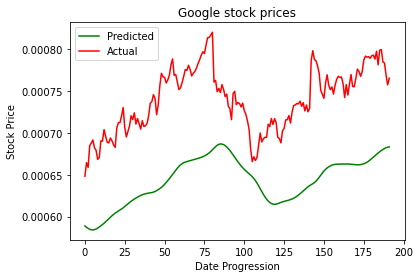

In [33]:
plt.figure()
plt.plot(p, color='green', label='Predicted')
plt.plot(y, color='red', label='Actual')
plt.title('Google stock prices')
plt.xlabel('Date Progression')
plt.ylabel('Stock Price')
plt.legend()
plt.show()